In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('lemma.csv')

print(df.isnull().sum())
df.dropna(subset=['lemmatized_text'], inplace=True)
print(df.isnull().sum())

Sınıf                0
lemmatized_text    126
dtype: int64
Sınıf              0
lemmatized_text    0
dtype: int64


In [3]:
import re

df.dropna(inplace=True)

def deleteunk(text):
    return re.sub(r'\bUNK\b','', text)

df["lemmatized_text"] = df["lemmatized_text"].apply(deleteunk)

In [4]:
from sklearn.model_selection import train_test_split

max_words = 200000000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['lemmatized_text'])
X = tokenizer.texts_to_sequences(df['lemmatized_text'])
X = pad_sequences(X, maxlen=max_len)
y = np.array(df['Sınıf'])



In [5]:
# Veri Bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [6]:
# Label Encoding ve One-Hot Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)


In [7]:
print(y_train_categorical.shape)
print(y_test_categorical.shape)
print(y_val_categorical.shape)

(891529, 9)
(297177, 9)
(297177, 9)


In [16]:
def log_evaluation_plot(booster, period=10, show_stdv=True):
    def _callback(env):
        if period > 0 and env.evaluation_result_list:
            keys = env.evaluation_result_list[0].keys()
            for eval_name, eval_result in env.evaluation_result_list:
                for metric_name, metric_result in eval_result.items():
                    print(f'{metric_name}-{eval_name} : {metric_result}')
        return
    _callback.order = 10
    return _callback

In [17]:
from lightgbm import Dataset, train, early_stopping, log_evaluation

# LightGBM için veri hazırlığı
train_data = Dataset(X_train, label=y_train_encoded)
val_data = Dataset(X_val, label=y_val_encoded, reference=train_data)

# Model parametreleri
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

In [18]:
from lightgbm import early_stopping, log_evaluation

num_round = 400
bst = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[val_data],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10),  # Her 10 iterasyonda bir çıktı alın
        callbacks=[log_evaluation_plot(bst)]
    ]
)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.5617
[20]	valid_0's multi_logloss: 1.45813
[30]	valid_0's multi_logloss: 1.40226
[40]	valid_0's multi_logloss: 1.37082
[50]	valid_0's multi_logloss: 1.34591
[60]	valid_0's multi_logloss: 1.32443
[70]	valid_0's multi_logloss: 1.30523
[80]	valid_0's multi_logloss: 1.28757
[90]	valid_0's multi_logloss: 1.27224
[100]	valid_0's multi_logloss: 1.25476
[110]	valid_0's multi_logloss: 1.24066
[120]	valid_0's multi_logloss: 1.22548
[130]	valid_0's multi_logloss: 1.21147
[140]	valid_0's multi_logloss: 1.19817
[150]	valid_0's multi_logloss: 1.18519
[160]	valid_0's multi_logloss: 1.17247
[170]	valid_0's multi_logloss: 1.1603
[180]	valid_0's multi_logloss: 1.14858
[190]	valid_0's multi_logloss: 1.13707
[200]	valid_0's multi_logloss: 1.12631
[210]	valid_0's multi_logloss: 1.11611
[220]	valid_0's multi_logloss: 1.10632
[230]	valid_0's multi_logloss: 1.09725
[240]	valid_0's multi_logloss: 1.08822
[250]	valid_0'

In [ ]:
history = bst.eval_valid()

# Eğitim ve doğrulama kayıplarını alın
train_loss = [float(metric['multi_logloss']) for metric in history]
val_loss = [float(metric['multi_logloss']) for metric in history]

# Eğitim ve doğrulama doğruluklarını hesapla
train_accuracy = [1 - loss for loss in train_loss]
val_accuracy = [1 - loss for loss in val_loss]

# Grafik çizimi
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

                 precision    recall  f1-score   support

bilim-teknoloji       0.83      0.35      0.49     13741
 finans-ekonomi       0.96      0.48      0.64     13110
   kültür-sanat       0.55      0.26      0.35     19846
        magazin       0.69      0.88      0.77     97992
         sağlık       0.66      0.63      0.65     24599
        siyaset       0.61      0.83      0.71     61179
           spor       0.85      0.74      0.79     45714
         turizm       0.70      0.19      0.30     14360
          çevre       0.84      0.11      0.19      6636

       accuracy                           0.69    297177
      macro avg       0.74      0.50      0.54    297177
   weighted avg       0.71      0.69      0.67    297177



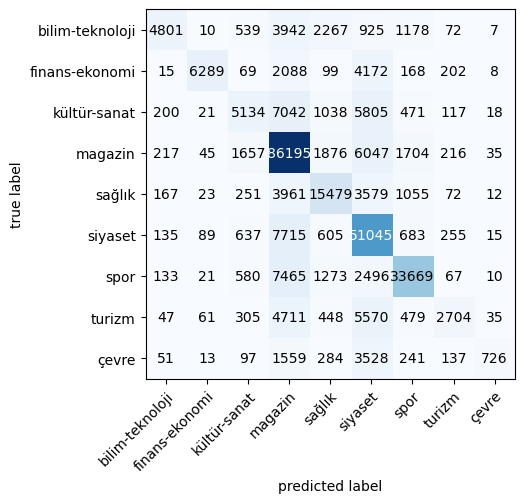

In [11]:
# LightGBM ile tahminlerin alınması
y_pred_labels = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_labels = np.argmax(y_pred_labels, axis=1)

# Sınıflandırma raporunun oluşturulması
class_names = label_encoder.classes_
print(classification_report(y_test_encoded, y_pred_labels, target_names=class_names))

# Confusion matrixin oluşturulması
conf_mat = confusion_matrix(y_test_encoded, y_pred_labels)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=conf_mat, class_names=class_names)
plt.show()


In [12]:
# Recall ve Precision hesaplama
recall = recall_score(y_test_encoded, y_pred_labels, average='weighted')
precision = precision_score(y_test_encoded, y_pred_labels, average='weighted')

print(f"Recall: {recall}")
print(f"Precision: {precision}")

Recall: 0.6933309105347991
Precision: 0.7102110575876786


In [13]:
bst.save_model('nlp_lightgbm_model00.txt')